# **CHECKPOINT 5:** Data selection, p-values, hypothesis testing and significance interpretation.

## S1867522

## **Generation of random distributions from a model**

## **PROBLEM 1**


Create two classes, one called Linear (to model the background distribution), and a second one called Gaussian (to model the signal distribution). For both of them add an attribute mass array (to be initialised in the constructor) to hold the mass values that will make up the spectrum of the background and signal distributions. Add also a next() member function to be used for drawing random x-values (ie. corresponding to the mass) according to the parent f(x) distribution. For class Gaussian use the built-in method numpy.random.normal to draw random values. For class Linear use the “box” method (as discussed in previous lectures):

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.special import erfinv
from scipy import integrate
from scipy import stats
from iminuit import Minuit

In [26]:
# class to model the background distribution 
class Linear:

    def __init__(self,intercept, slope, XMIN,XMAX):
        self.lolimit = XMIN     # minimum x
        self.hilimit = XMAX     # maximum x
        self.intercept = intercept   # intercept of the polynomial
        self.slope = slope     # slope of the polynomial
        self.mass = []   # mass values that will make up the spectrum

    def maxval(self):
        return self.intercept

    # Evaluate method (un-normalised)
    def evaluate(self, t):
        return self.intercept + self.slope * t

    def next(self): 
        doLoop = True
        while(doLoop):
            # start with uniform random number in [lolimit, hilimit) 
            x = np.random.uniform(self.lolimit , self.hilimit)
            y1 = self.evaluate(x)
        
            y2 = np.random.uniform(0, self.maxval())
            
            # store the filtered_x values in the mass array for later plotting
            if (y2 < y1):
                filtered_x = x 
                self.mass.append(filtered_x) 
                return filtered_x

            
# class to model the signal distribution 
class Gaussian:

    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
        self.mass = []  # mass values that will make up the spectrum

    def next (self):

        # store the x values in the mass array for later plotting
        x = np.random.normal(self.mean, self.sigma)
        self.mass.append(x)

        return x

    

Note how we store the accepted (“filtered”) values of mass in variable mass array so we can access them later for plotting.
Now create class SignalWithBackground which will return the sum of the signal (Signal) and background (Linear) distributions weighted by the fractions of signal and back- ground events:

In [37]:
class SignalWithBackground:
    
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX ):
        
        self.mean = mean
        self.sigma =sigma
        self.intercept = intercept
        self.slope =slope
        self.lolimit = XMIN
        self.hilimit = XMAX
        self.signal = Gaussian(self.mean, self.sigma)   
        self.background = Linear(self.intercept, self.slope, self.lolimit,self.hilimit)
        self.sig_fraction = sig_fraction
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = []


    # Draw random number form distribution
    def next(self):
        q = np.random.uniform() 
        if( q < self.sig_fraction):
            # if here, we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x) 
        else:
            # if here, we will draw x from background distribuion
            filtered_x = self.background.next() 
            self.mass_bgd.append(filtered_x)
        
        self.mass.append(filtered_x) 
            
        return filtered_x

    #def pdf_gauss(x, sigma, mean):

        #return (np.sqrt(2*np.pi*sigma**2))**(-1)*np.exp(-(x - mean)**2/(2*sigma**2))



In [38]:
# background parameters
XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.
# signal parameters
mean = 10.
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample 
NBINS = 100

Note how we keep track separately of drawn mass values for signal (mass sig) and back- ground (mass bgd) , but also for their sum (mass).
Now put everything together with something like the following snippet (lots of little details omitted!), and plot the three distributions:

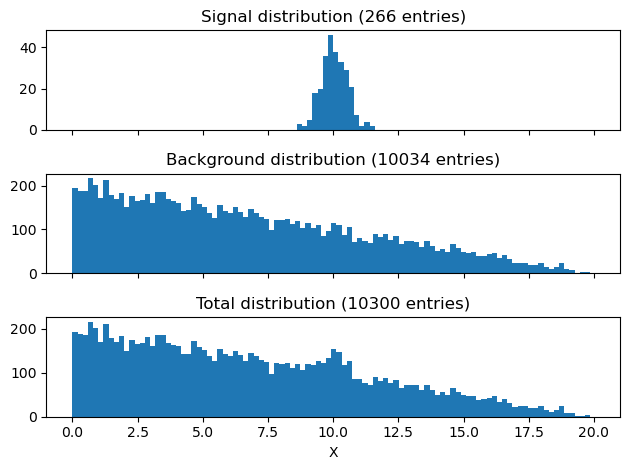

In [45]:
# Main code to generate and plot a single experiment
def singleToy(nevents_sig = 300, nevents_bgd = 10000):

        
    sig_fraction = nevents_sig/(nevents_bgd + nevents_sig)
    #Create the pdf
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX ) 
    
    for i in range( nevents_sig + nevents_bgd ): pdf.next()

    # retrieve the mass values for signal, background and their sum
    data = pdf.mass 
    sig_data = pdf.mass_sig 
    bgd_data = pdf.mass_bgd

    # plot things on same page
    myRange = (XMIN, XMAX)
    fig, axs = plt.subplots(3,1, sharex="col")

    axs[0].set_title("Signal distribution (" + str(len(sig_data)) + " entries)") 
    axs[1].set_title("Background distribution (" + str(len(bgd_data)) + " entries)") 
    axs[2].set_title("Total distribution (" + str(len(data)) + " entries)") 
    axs[2].set_xlabel("X")
    
    axs[0].hist(sig_data, bins=NBINS, range=myRange) 
    axs[1].hist(bgd_data, bins = NBINS) 
    axs[2].hist(data, bins = NBINS) 
    fig.tight_layout()
    plt.savefig("Example1.pdf")

    return data, bgd_data

data, bgd_data  = singleToy()

## **p-values: quantifying background fluctuations**

## **PROBLEM 2**

Calculate the probability that a background-only process with λ = 10, 000 can fluctuate to give k ≥ 10, 300. The fastest way to do this is to employ the previously coded Gaussian class, by adding an integral() method, which can be easily implemented with method scipy.integrate.quad. You will need to take the ratio of two such integrals.
Calculate how large the deviation is by converting the p-value to a Z-score (or number of standard deviations). You can use the inverse error function1, as shown in the following snippet:

In [41]:
def pdf(x, sigma, mean):
    return (np.sqrt(2*np.pi*sigma**2))**(-1)*np.exp(-(x - mean)**2/(2*sigma**2))

In [42]:
pvalue = integrate.quad(pdf, 10300, np.inf, args = (100,10000))


n_sigmas = erfinv(1 - pvalue[0])* np.sqrt(2)

n_sigmas

3.2051549205206973

## **PROBLEM 3**

First, confirm that the number of (expected) background events in the 5 < x < 15 subregion is 50%. Then, calculate the p-value and the Z-score as in the previous problem for the updated λ and k values. You will notice that the deviation is more significant now. Why?

Percentage of background events in total number of events = 48.28155339805825


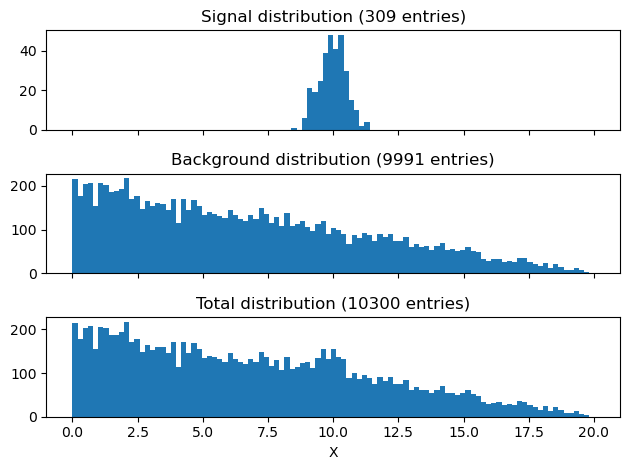

In [46]:
data, bgd_data = singleToy()
bg_data_red = []
for i in range(len(bgd_data)):
    if bgd_data[i] >= 5 and bgd_data[i] <= 15:
        bg_data_red.append(bgd_data)
        

print("Percentage of background events in total number of events =", len(bg_data_red)/len(data)*100)


In [44]:
pvalue_2 = integrate.quad(pdf, 5300, np.inf, args = (np.sqrt(5000), 5000))

n_sigmas_2 = erfinv(1 - pvalue_2[0])* np.sqrt(2)

n_sigmas_2

4.39562892080614

## **Hypothesis testing: H0 vs. H1**

## **PROBLEM 4**

In this example you should decrease the population of signal events to 150 (or ∼1.5% of the total sample). Despite having a weaker signal, the shape-based analysis provides a much more powerful statistical test than mere event-counting. You should carry out two fits on the same “data” histogram, one assuming no signal (H0), and a second one assuming a signal (H1) of uknown size (but with fixed mean and sigma values). In both fits the shape of the background distribution (slope and intercept) should be free to vary. Find the difference in the (log-likelihood-equivalent) χ2 between the H0 and H1 fits. Since the difference in the number of degress of freedom between the two models is just one (the size of the signal contribution), you should use this information and Wilk’s theorem to calculate the p-value and the Z-score (method scipy.stats.chi2.cdf can be used here).

In [221]:
signal_events = 150
bgd_events = 10000
total_events = signal_events + bgd_events
signal_ratio = signal_events/total_events
bgd_ratio = bgd_events/total_events

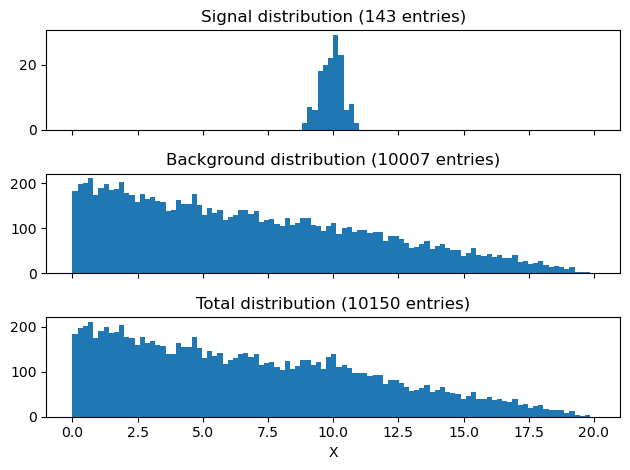

In [204]:
data, bgd_data = singleToy(nevents_sig = signal_events, nevents_bgd = bgd_events)

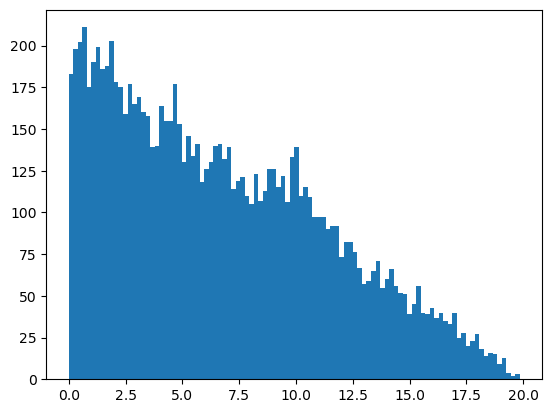

In [205]:
y1, x1, patches = plt.hist(data, bins = 100)

## Null Hypothesis (H0)

In [206]:
def pdf_lin (x, m, c):


    polyn = lambda x: (c + m*x)
    integ = integrate.quad(polyn,0,20)[0]
    pdf_polyn = (c + m*np.array(x)) 

    pdf_tot = (pdf_polyn/integ) 
    pdf_tot[pdf_tot<1e-3] = 1e-3

    return pdf_tot

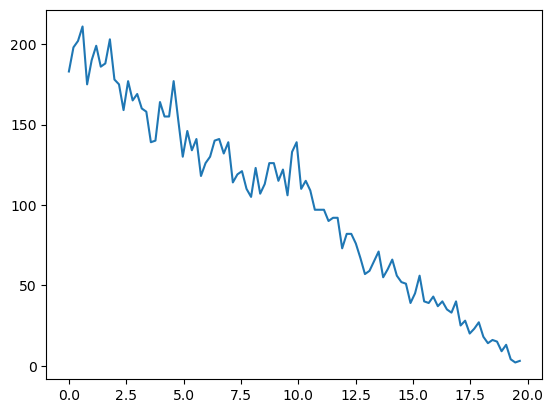

In [207]:
plt.plot(x1[:-1], y1)

In [208]:
def NLL_linear(m,c):

    return -np.sum(np.log(pdf_lin(data, m,c)))

In [209]:
# Estimate best value using Minuit

m_comb_0 = Minuit(NLL_linear, m = -12, c = 200)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_0.migrad()  # run optimiser
m_comb_0.hesse()   # run covariance estimator

print(m_comb_0.values)  # print estimated values
print(m_comb_0.errors)  # print error of the estimated values

<ValueView m=-9.998817887101097 c=199.15608583558745>
<ErrorView m=1.1441496401341493 c=22.789291469780576>


In [210]:
area = sum((x1[1] - x1[0]) * y1)

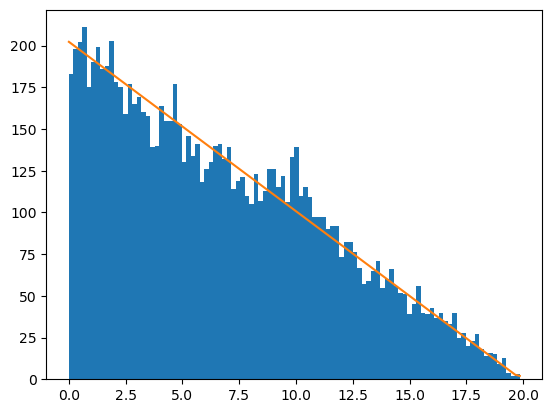

In [211]:
plt.hist(data, bins =100)
plt.plot(x1, pdf_lin(x1, m_comb_0.values[0], m_comb_0.values[1])*area)

## "Signal" Hypothesis (H1)

In [226]:
def pdf_comb (x, m, c, signal_ratio = signal_ratio, bgd_ratio = bgd_ratio):

    # signal parameters
    mean = 10.
    sigma = 0.5



    # range [0,20]

    gaussian = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(np.array(x)-mean)**2 / (2*(sigma**2))) 

    polyn = lambda x: (c + m*x)
    integ = integrate.quad(polyn,0,20)[0]
    pdf_polyn = (c + m*np.array(x)) 

    pdf_tot = bgd_ratio*(pdf_polyn/integ) + signal_ratio* ( gaussian )
    pdf_tot[pdf_tot<1e-3] = 1e-3

    return pdf_tot

In [227]:
def NLL_comb(m,c):

    return -np.sum(np.log(pdf_comb(data, m,c)))

In [228]:
# Estimate best value using Minuit

m_comb_1 = Minuit(NLL_comb, m = -12, c = 200)

# m_comb_0.errordef = Minuit.LIKELIHOOD
m_comb_1.migrad()  # run optimiser
m_comb_1.hesse()   # run covariance estimator

print(m_comb_1.values)  # print estimated values
print(m_comb_1.errors)  # print error of the estimated values

<ValueView m=-10.804999899208006 c=215.2089045794814>
<ErrorView m=1.2744002740324734 c=25.38288803194886>


In [242]:
exp0 = pdf_lin(x1[:-1], m_comb_0.values[0], m_comb_0.values[1])
chi0 = 2*np.sum(exp0 - y1 + y1*np.log(y1/exp0))

In [243]:
exp1 = pdf_lin(x1[:-1], m_comb_1.values[0], m_comb_1.values[1])
chi1 = 2*np.sum(exp1 - y1 + y1*np.log(y1/exp1))

In [257]:
difchi = np.abs(chi0-chi1)
difchi

0.012902417598525062

In [256]:
p = stats.chi2.cdf(difchi,1)
p

0.09043624118477485

In [255]:
n_sigmas = erfinv(1 - p)* np.sqrt(2)
n_sigmas

1.6931010147043963

## **PROBLEM 5**

In [237]:
a = -2*np.log(dif_chi)
print(a)

-5.372631161471725


Run a large number of toy MC experiments by carrying out H0 and H1 fits but this time on spectra (i.e. the x-observable) that contain only background events. The number of background-only pseudo-experiments that you should generate depends on the p-value found in the previous problem, however it should be at least a thousand or so. You should fit the data each time to both H0 and H1 models and produce the corresponding χ2(H0) − χ2(H1) distribution.
Compare the tail of this distribution with the ∆χ2 you found in the previous exercise. Is the observation consistent with Wilk’s theorem?